# 使用 ARIMA 模型进行时间序列分析和预测——以月度游客数量为例

## 引言

ARIMA（AutoRegressive Integrated Moving Average，自回归整合移动平均）模型是一种广泛应用于时间序列分析的统计模型。它能捕捉数据中的自相关结构，对具有趋势或非平稳性的时间序列数据进行建模和预测。

本次案例将以**月度游客数量**为例，演示如何使用 ARIMA 模型对时间序列数据进行分析和预测。

## 数据准备

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# 读取数据
df = pd.read_csv('../data/tourists.csv', parse_dates=['Date'], index_col='Date')

# 查看数据前5行
df.head()

,Tourists
Date,
1999-01-01,30.052513
1999-04-01,19.148496
1999-07-01,25.317692
1999-10-01,27.591437
2000-01-01,32.076456


In [10]:
df.tail()

,Tourists
Date,
2009-10-01,45.642292
2010-01-01,59.766780
2010-04-01,35.191877
2010-07-01,44.319737
2010-10-01,47.913736


### 数据可视化

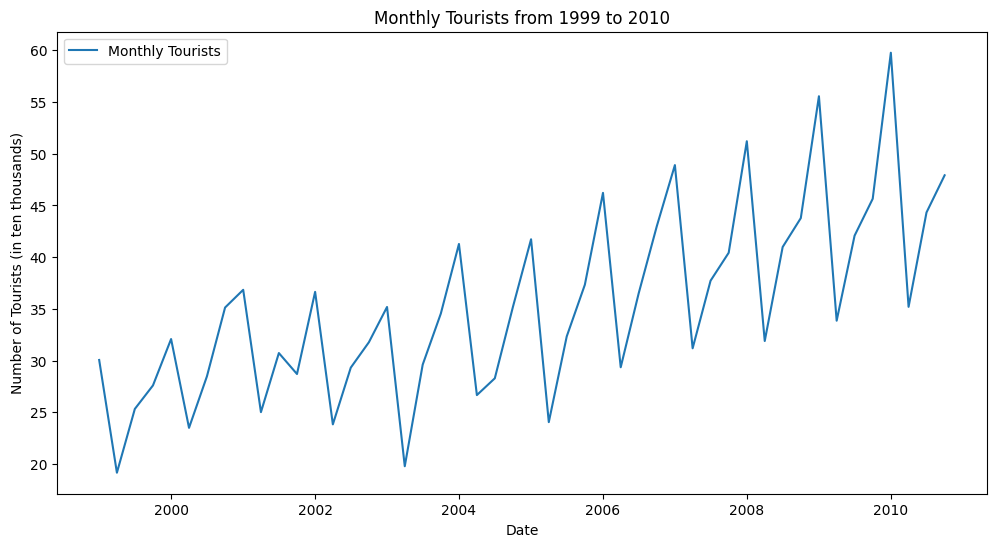

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Tourists'], label='Monthly Tourists')
plt.title('Monthly Tourists from 1999 to 2010')
plt.xlabel('Date')
plt.ylabel('Number of Tourists (in ten thousands)')
plt.legend()
plt.show()

## 数据预处理

### 平稳性检验

In [12]:
from statsmodels.tsa.stattools import adfuller

# 进行 ADF 检验
result = adfuller(df['Tourists'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.062688
p-value: 0.994885


### 差分处理

In [13]:
# 一阶差分
df['Diff_1'] = df['Tourists'].diff()
df_diff = df['Diff_1'].dropna()

# 差分后数据的 ADF 检验
result_diff = adfuller(df_diff)
print('ADF Statistic after differencing: %f' % result_diff[0])
print('p-value after differencing: %f' % result_diff[1])

ADF Statistic after differencing: -2.403305
p-value after differencing: 0.140806


In [14]:
# 二阶差分
df['Diff_2'] = df['Diff_1'].diff()
df_diff = df['Diff_2'].dropna()

# 差分后数据的 ADF 检验
result_diff = adfuller(df_diff)
print('ADF Statistic after differencing: %f' % result_diff[0])
print('p-value after differencing: %f' % result_diff[1])

ADF Statistic after differencing: -6.037535
p-value after differencing: 0.000000


## 模型识别

### 自相关函数（ACF）和偏自相关函数（PACF）

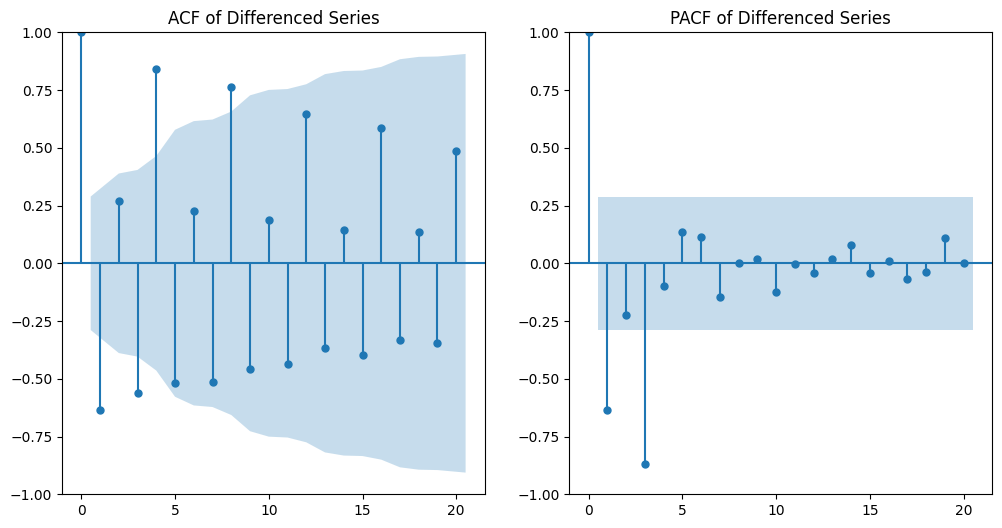

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(df_diff, ax=plt.gca(), lags=20)
plt.title('ACF of Differenced Series')
plt.subplot(122)
plot_pacf(df_diff, ax=plt.gca(), lags=20)
plt.title('PACF of Differenced Series')
plt.show()

## 模型建立

### 建立 ARIMA 模型

In [16]:
from statsmodels.tsa.arima.model import ARIMA

# 建立 ARIMA(1,1,0) 模型
model = ARIMA(df['Tourists'], order=(1, 2, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Tourists   No. Observations:                   48
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -169.286
Date:                Sat, 26 Oct 2024   AIC                            344.572
Time:                        11:22:51   BIC                            350.058
Sample:                    01-01-1999   HQIC                           346.627
                         - 10-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4593      0.302     -1.521      0.128      -1.051       0.133
ma.L1         -0.9995     23.368     -0.043      0.966     -46.800      44.801
sigma2        82.9138   1933.803      0.043      0.9

/root/miniconda3/envs/d2l/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/root/miniconda3/envs/d2l/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/root/miniconda3/envs/d2l/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


## 模型检验

### 残差分析

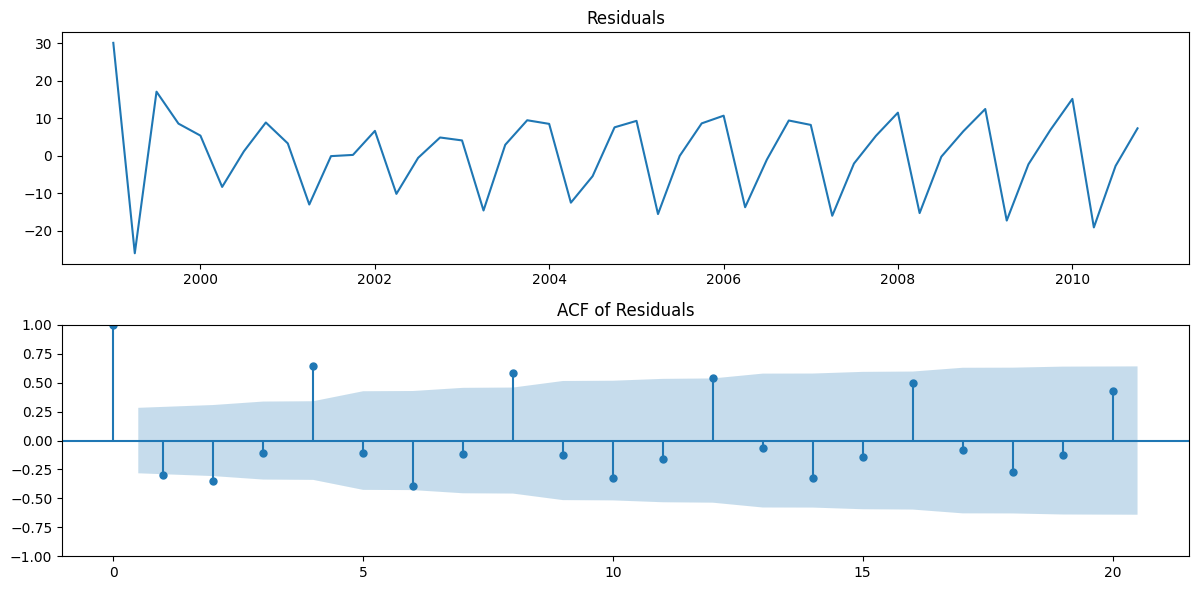

In [17]:
# 提取残差
residuals = model_fit.resid

# 绘制残差图
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')

# 绘制残差的 ACF 图
plt.subplot(212)
plot_acf(residuals, ax=plt.gca(), lags=20)
plt.title('ACF of Residuals')
plt.tight_layout()
plt.show()

## 模型应用与预测

### 未来趋势预测

In [18]:
# 预测未来
forecast = model_fit.forecast(steps=12)
forecast

2011-01-01    46.897649
2011-04-01    47.998860
2011-07-01    48.127648
2011-10-01    48.703047
2012-01-01    49.073328
2012-04-01    49.537814
2012-07-01    49.959035
2012-10-01    50.400126
2013-01-01    50.832091
2013-04-01    51.268248
2013-07-01    51.702479
2013-10-01    52.137595
Freq: QS-OCT, Name: predicted_mean, dtype: float64

### 预测结果可视化

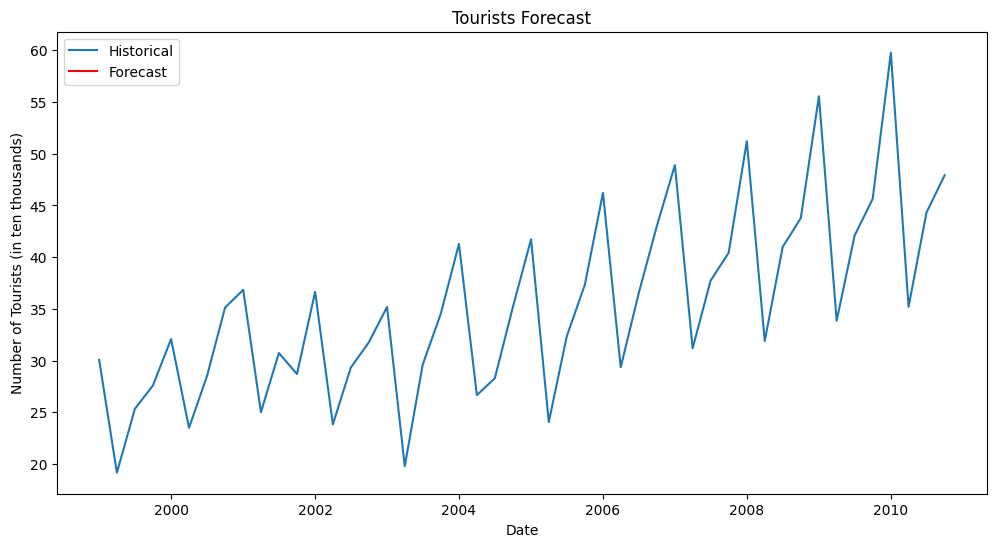

In [19]:
# 构建预测结果的时间索引
future_dates = pd.date_range(start=df.index[-1], periods=13, freq='M')[1:]
forecast_series = pd.Series(forecast, index=future_dates)

# 绘制预测结果
plt.figure(figsize=(12,6))
plt.plot(df['Tourists'], label='Historical')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('Tourists Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Tourists (in ten thousands)')
plt.legend()
plt.show()